# SqueezeNet

In this file we train the SqueezeNet model as described in the paper found [here](https://arxiv.org/abs/1602.07360).
This implementation uses the CIFAR10 dataset.

Optimization Steps (didn't converge initially)
 1. added MSR initialization (Epoch [100/100] Train Loss: 0.1352, Train Acc: 95.27% Test/Val Loss: 1.1394, Test/Val Acc: 75.05%)
 2. added batchnorm (Epoch [100/100] Train Loss: 0.0758, Train Acc: 97.39% Test/Val Loss: 0.8656, Test/Val Acc: 80.68%)
 3. added dropout b/w fire modules (Epoch [100/100] Train Loss: 0.0994, Train Acc: 96.70% Test/Val Loss: 0.7113, Test/Val Acc: 81.81%)
 4. added data augmentation (Epoch [100/100] Train Loss: 0.4987, Train Acc: 83.31% Test/Val Loss: 0.3416, Test/Val Acc: 88.23%)

Pruning:

10%: Epoch [10/10] Train Loss: 0.4922, Train Acc: 83.40% Test/Val Loss: 0.3409, Test/Val Acc: 88.27%

30%: Epoch [10/10] Train Loss: 0.4935, Train Acc: 83.60% Test/Val Loss: 0.3446, Test/Val Acc: 88.24%

50%: Epoch [10/10] Train Loss: 0.4830, Train Acc: 83.78% Test/Val Loss: 0.3306, Test/Val Acc: 88.71%

70%: Epoch [10/10] Train Loss: 0.4505, Train Acc: 84.93% Test/Val Loss: 0.3414, Test/Val Acc: 88.30%

Quantization:
QAT: Epoch [20/20] Train Loss: 0.7070, Train Acc: 76.26% Test/Val Loss: 0.5349, Test/Val Acc: 81.65%
No QAT: 10% meaning effectively random outputs

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import helper
from squeezenet_model import SqueezeNetCIFAR10
from alexnet_model import AlexNetCIFAR10
from resnet32_model import ResNet32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device={device}")

Device=cuda


## Training

The class in this cell below defines our architecture and defines our forward pass. We insert quantization stub for later Quantization Aware Training. We also define helper functions to save and load the model.

After these definitions we will train the model.

## Load the Dataset

In this cell we define a function to load our dataset.

In [ ]:
train_loader, test_loader = helper.load_dataset(batch_size=128)

## Train the model

In the cells below we define a function to visualize our training and train our model

In [ ]:
model_fp32 = SqueezeNetCIFAR10()
mname = "squeezenet"
# model_fp32.load_model('squeezenet_bn_cifar10_fp32.pth')

total_params = sum(p.numel() for p in model_fp32.parameters())
print(f"Total parameters: {total_params}")

trainable_params = sum(p.numel() for p in model_fp32.parameters() if p.requires_grad)
print(f"Trainable parameters: {trainable_params}")

In [ ]:
train, test = True, True
epochs = 100
fp32_metrics = helper.train_model(model=model_fp32,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

In [ ]:
model_fp32.save_model(f"{mname}_baseline_fp32.pth")

In [ ]:
helper.plot_metrics(fp32_metrics)

In [ ]:
helper.plot_weight_histogram(model_fp32)

## Pruning

Next we will attempt to prune the model

In [ ]:
model = SqueezeNetCIFAR10()
model.load_model(f"{mname}_baseline_fp32.pth", device=device)
model.train()

In [ ]:
import copy
import torch.nn.utils.prune as prune

prune_levels = [0.1, 0.3, 0.5, 0.7]
results = []

for p in prune_levels:
    m = copy.deepcopy(model)

    parameters_to_prune = []
    for module in m.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            parameters_to_prune.append((module, "weight"))

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=p
    )

    # fine-tune
    metrics = helper.train_model(model=m,train_loader=train_loader,test_loader=test_loader,device=device)

    # remove pruning masks
    for module in m.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.remove(module, "weight")

    percent = p * 100
    m.save_model(f"pruned_{percent}.pth")

    results.append((p, metrics))

In [ ]:
for p, metrics in results:
    print(f"Metrics for pruning with p={p}")
    helper.plot_metrics(metrics)

## Quantization Aware Training

Next we will use QAT to prepare the model for quantization and analyze the effects. At the end we can see that QAT led to slightly higher accuracy compared to quantization without.

In [ ]:
import torch
from torch.ao.quantization import get_default_qat_qconfig
from torch.ao.quantization.quantize_fx import prepare_qat_fx, convert_fx

model_qat = SqueezeNetCIFAR10()
model_qat.load_model("squeezenet_p50.pth", device='cpu')
model_qat.eval()

# example input for FX tracing
example_inputs = (torch.randn(1, 3, 32, 32, device='cpu'),)

# QAT config dictionary, default 8-bit symmetric QAT
qconfig_dict = {"": get_default_qat_qconfig('fbgemm')}

# prepare the model for QAT
model_qat_prepared = prepare_qat_fx(model_qat, qconfig_dict, example_inputs=example_inputs)

model_qat_prepared.to(device)
model_qat_prepared.train()

In [ ]:
train, test = True, True
epochs = 20
qat_metrics = train_model(model=model_qat_prepared,train_loader=train_loader,test_loader=test_loader,train=train,test=test,device=device,epochs=epochs)

Epoch [1/20] 

Train Loss: 1.9300, Train Acc: 26.51% 

Test/Val Loss: 1.6477, Test/Val Acc: 40.18%
Epoch [2/20] 

Train Loss: 1.5165, Train Acc: 45.50% 

Test/Val Loss: 1.1985, Test/Val Acc: 55.28%
Epoch [3/20] 

Train Loss: 1.3088, Train Acc: 53.66% 

Test/Val Loss: 1.0290, Test/Val Acc: 63.59%
Epoch [4/20] 

Train Loss: 1.1926, Train Acc: 58.20% 

Test/Val Loss: 0.8844, Test/Val Acc: 69.04%
Epoch [5/20] 

Train Loss: 1.0959, Train Acc: 62.13% 

Test/Val Loss: 0.8276, Test/Val Acc: 71.55%
Epoch [6/20] 

Train Loss: 1.0281, Train Acc: 64.73% 

Test/Val Loss: 0.7239, Test/Val Acc: 75.18%
Epoch [7/20] 

Train Loss: 0.9701, Train Acc: 66.85% 

Test/Val Loss: 0.7284, Test/Val Acc: 74.49%
Epoch [8/20] 

Train Loss: 0.9303, Train Acc: 68.40% 

Test/Val Loss: 0.6866, Test/Val Acc: 76.34%
Epoch [9/20] 

Train Loss: 0.8965, Train Acc: 69.70% 

Test/Val Loss: 0.6395, Test/Val Acc: 77.83%
Epoch [10/20] 

Train Loss: 0.8578, Train Acc: 70.96% 

Test/Val Loss: 0.6079, Test/Val Acc: 79.26%
Epoch [11/20] 

Train Loss: 0.8465, Train Acc: 71.51% 

Test/Val Loss: 0.6050, Test/Val Acc: 79.24%
Epoch [12/20] 

Train Loss: 0.8167, Train Acc: 72.53% 

Test/Val Loss: 0.6270, Test/Val Acc: 78.96%
Epoch [13/20] 

Train Loss: 0.8043, Train Acc: 72.92% 

Test/Val Loss: 0.5972, Test/Val Acc: 79.42%
Epoch [14/20] 

Train Loss: 0.7880, Train Acc: 73.42% 

Test/Val Loss: 0.5477, Test/Val Acc: 81.40%
Epoch [15/20] 

Train Loss: 0.7723, Train Acc: 73.82% 

Test/Val Loss: 0.5486, Test/Val Acc: 80.86%
Epoch [16/20] 

Train Loss: 0.7563, Train Acc: 74.28% 

Test/Val Loss: 0.5129, Test/Val Acc: 82.75%
Epoch [17/20] 

Train Loss: 0.7466, Train Acc: 74.90% 

Test/Val Loss: 0.5148, Test/Val Acc: 82.29%
Epoch [18/20] 

Train Loss: 0.7314, Train Acc: 75.41% 

Test/Val Loss: 0.5216, Test/Val Acc: 81.82%
Epoch [19/20] 

Train Loss: 0.7253, Train Acc: 75.39% 

Test/Val Loss: 0.5120, Test/Val Acc: 82.12%
Epoch [20/20] 

Train Loss: 0.7070, Train Acc: 76.26% 

Test/Val Loss: 0.5349, Test/Val Acc: 81.65%


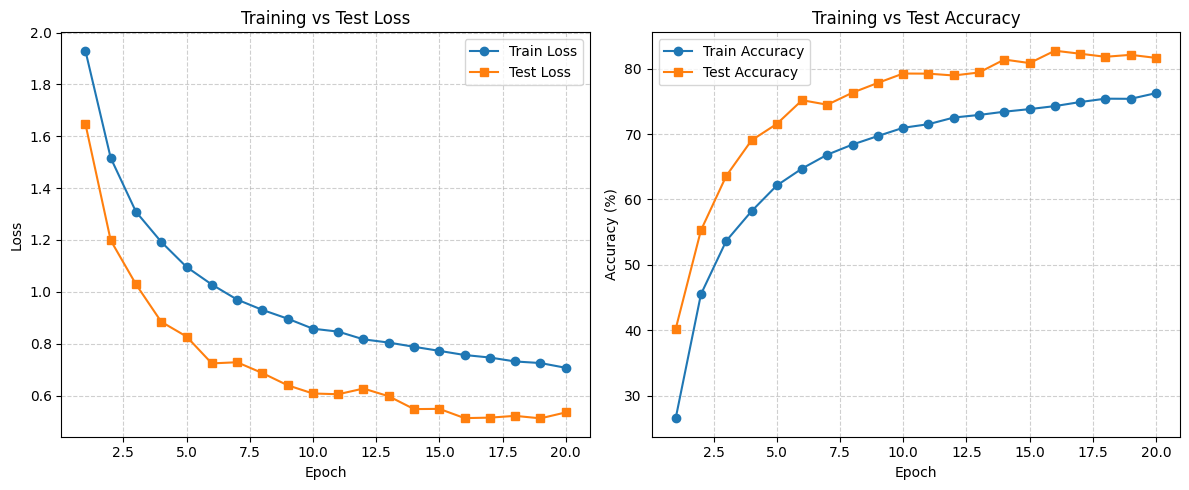

In [ ]:
plot_metrics(qat_metrics)

In [ ]:
# convert to INT8
model_qat_prepared.eval()
model_int8 = convert_fx(model_qat_prepared.cpu())
torch.save(model_int8.state_dict(), "squeezenet_int8_qat.pth")
# model_int8.load_state_dict(torch.load("squeezenet_int8_qat.pth"))
# model_int8.eval()

/tmp/SLURM_5175335/ipykernel_2912959/1725404078.py:3: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8 = convert_fx(model_qat_prepared.cpu())


In [ ]:
def evaluate(model, test_loader):
    model.eval()
    model.to('cpu')
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to('cpu'), labels.to('cpu')
            outputs = model(images)
            _, pred = outputs.max(1)
            correct += pred.eq(labels).sum().item()
            total += labels.size(0)

    acc = 100.0 * correct / total
    return acc

acc = evaluate(model_int8,test_loader)
print(f"INT8 with QAT Test Accuracy: {acc}%")

INT8 with QAT Test Accuracy: 81.49%


In [ ]:
from torch.ao.quantization import get_default_qconfig
from torch.ao.quantization.quantize_fx import prepare_fx, convert_fx

model_fp32 = SqueezeNetCIFAR10()
model_fp32.load_model("squeezenet_p50.pth", device='cpu')
model_fp32.eval()

example_inputs = (torch.randn(1, 3, 32, 32),)

qconfig_dict = {"": get_default_qconfig('fbgemm')}

model_ptq_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs)

calibration_loader = DataLoader(train_loader.dataset, batch_size=32, shuffle=False)

model_ptq_prepared.eval()

# calibrate model by observing activations
with torch.inference_mode():
    for i, (x, _) in enumerate(calibration_loader):
        model_ptq_prepared(x)
        if i == 20:
            break

Model loaded from squeezenet_p50.pth


/tmp/SLURM_5175335/ipykernel_2912959/1477844450.py:12: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_ptq_prepared = prepare_fx(model_fp32, qconfig_dict, example_inputs)
/home1/kodachi/.conda/envs/ee599/lib/python3.12/site-packages/torch/ao/quantization/quantize_fx.py:146: FutureWarning: Passing a QConfig dictionary to prepare is deprecated and will not be supported

In [ ]:
model_int8_ptq = convert_fx(model_ptq_prepared)
acc = evaluate(model_int8_ptq,test_loader)
print(f"INT8 Wihtout QAT Test Accuracy: {acc}%")

/tmp/SLURM_5175335/ipykernel_2912959/1888138913.py:1: DeprecationWarning: torch.ao.quantization is deprecated and will be removed in 2.10. 
For migrations of users: 
1. Eager mode quantization (torch.ao.quantization.quantize, torch.ao.quantization.quantize_dynamic), please migrate to use torchao eager mode quantize_ API instead 
2. FX graph mode quantization (torch.ao.quantization.quantize_fx.prepare_fx,torch.ao.quantization.quantize_fx.convert_fx, please migrate to use torchao pt2e quantization API instead (prepare_pt2e, convert_pt2e) 
3. pt2e quantization has been migrated to torchao (https://github.com/pytorch/ao/tree/main/torchao/quantization/pt2e) 
see https://github.com/pytorch/ao/issues/2259 for more details
  model_int8_ptq = convert_fx(model_ptq_prepared)


INT8 Wihtout QAT Test Accuracy: 10.0%
